In [1]:
using HDF5
using Plots

using Suppressor
using Logging
using Distributed
#if nprocs() == 1
#    addprocs(7)
#end
using LadderDGA

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config_large.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config_large2.toml"
cfg_file3 = "$(@__DIR__)/../../lDGA_test_runs/config_large3.toml"


empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");


io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
mP, sP, env, kGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGridLoc2, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

mP3, sP3, env3, kGrids, qGridLoc3, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file3)
νGrid3, sumHelper_f3, impQ_sp3, impQ_ch3, GImp_fft3, GLoc_fft3, Σ_loc3, FUpDo3, gImp3, gLoc3 = setup_LDGA(kG, freqList, mP3, sP3, env3);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 38:64 and 38:64 to the same range of 38:64
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(38:64) = 0.3182, χLoc_ch(38:64) = 0.1222 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.2201987037827738 ?≈? 0.22019870378277384 ?=? 0.22019870378277384 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 2:100 and 2:100 to the same range of 2:100
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(2:100) = 0.3462, χLoc_ch(2:100) = 0.1447 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.24542477850524352 ?≈? 0.24542477850524358 ?=? 0.24542477850524358 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: 

# Lambda charge solutions investigation

In [3]:
# DMFT Energies
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:length(GImp)], ϵₖ, Vₖ, GImp, mP);

In [4]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP)
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc  = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo, qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [5]:
# "local" correction quantities
bubbleLoc2 = calc_bubble(νGrid, GImp_fft2, qGridLoc2, mP2, sP2)
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo2, qGridLoc2, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

In [6]:
# "local" correction quantities
bubbleLoc3 = calc_bubble(νGrid, GImp_fft3, qGridLoc3, mP3, sP3)
locQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, mP3.U, mP2, sP3);
locQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubbleLoc3, qGridLoc3, νGrid3, sumHelper_f3, -mP3.U, mP2, sP3);
Σ_ladderLoc3 = calc_Σ(locQ_sp3, locQ_ch3, bubbleLoc3, GImp_fft3, FUpDo3, qGridLoc3, sumHelper_f3, mP3, sP3)
Σ_ladderLoc3 = Σ_ladderLoc3 .+ mP3.n * mP3.U/2.0;

In [7]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [8]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, kG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, kG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, kG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

In [9]:
# non local quantities 
bubble3 = calc_bubble(νGrid, GLoc_fft3, kG, mP3, sP3);
nlQ_sp3 = calc_χ_trilex(impQ_sp3.Γ, bubble3, kG, νGrid3, sumHelper_f3, mP3.U, mP3, sP3);
nlQ_ch3 = calc_χ_trilex(impQ_ch3.Γ, bubble3, kG, νGrid3, sumHelper_f3, -mP3.U, mP3, sP3);

In [10]:
usable_ω = intersect(impQ_sp.usable_ω, impQ_ch.usable_ω)
χupup_DMFT_ω = real(impQ_sp.χ_ω .+ impQ_ch.χ_ω)[usable_ω] ./ 2

usable_ω2 = intersect(impQ_sp2.usable_ω, impQ_ch2.usable_ω)
χupup_DMFT_ω2 = real(impQ_sp2.χ_ω .+ impQ_ch2.χ_ω)[usable_ω2] ./ 2

χupup_ω_csum = LadderDGA.build_fνmax_fast(χupup_DMFT_ω, 50);
χupup_ω_csum2 = LadderDGA.build_fνmax_fast(χupup_DMFT_ω2, 50);

iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
iωn2 = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω2] .* π ./ mP.β
EKin = impQ_sp.tailCoeffs[3]
χupup_DMFT_ω_sub = LadderDGA.subtract_tail(χupup_DMFT_ω,EKin, iωn)
χupup_DMFT_ω_sub2 = LadderDGA.subtract_tail(χupup_DMFT_ω2,EKin, iωn2)

χupup_ω_sub_csum = LadderDGA.build_fνmax_fast(χupup_DMFT_ω_sub, 50);
χupup_ω_sub_csum2 = LadderDGA.build_fνmax_fast(χupup_DMFT_ω_sub2, 50);

println("TODO: tail for chi up do?")
χupdo_DMFT_ω2 = real(impQ_ch2.χ_ω .- impQ_sp2.χ_ω)[usable_ω2] ./ 2
χupdo_ω_csum2 = LadderDGA.build_fνmax_fast(χupdo_DMFT_ω2, 50);
χupdo_ω_sub_csum2 = χupdo_ω_csum2;

TODO: tail for chi up do?


In [11]:
exps_l = [0:i for i in 1:6]

res = zeros(length(exps_l),  50 - 1,4)  # no nu fit, nu fit, no nu fit + sub, nu fit + sub
for (j,exps) in enumerate(exps_l)
for i in 1:50 - maximum(exps)
    ind = exps .+ i
    sh = LadderDGA.Richardson(ind,exps,method=:bender)
    sh2 = LadderDGA.Richardson(exps .+ 1,exps,method=:bender)
    res[j,i,1] = real.(sum(χupdo_ω_csum2[ind])) ./ mP2.β
    res[j,i,2] = LadderDGA.esum_c(real.(χupdo_ω_sub_csum2)[ind] ./ mP2.β, sh2)
    res[j,i,3] = LadderDGA.esum_c(real.(χupup_ω_csum2)[ind]./ mP2.β, sh2) 
    res[j,i,4] = LadderDGA.esum_c(real.(χupup_ω_sub_csum2)[ind]./ mP2.β, sh2)  .- EKin*mP.β/12
end
end

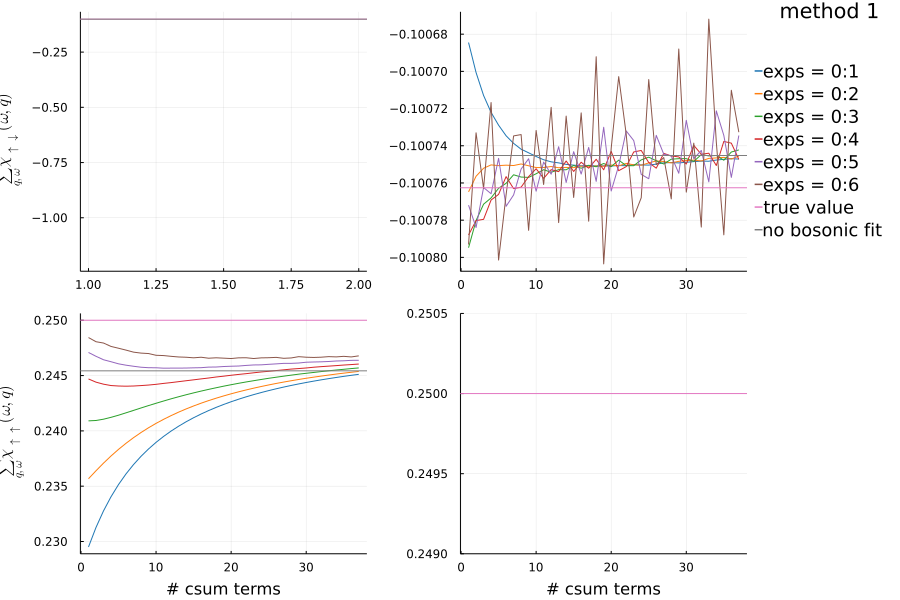

In [12]:
using Plots
using LaTeXStrings
#l = @layout([[A B] E{.15w}])
l = @layout([[A B; C D] E{.15w}])
# method $method
colors = palette(:tab10)
p = Array{Plots.Plot,1}(undef, 5)
v1 = χupdo_ω_sub_csum2[end] ./ mP.β 
v2 = χupup_ω_sub_csum2[end] ./ mP.β .- EKin*mP.β/12
ind = 8:(size(res,2)-5)

p[1] = plot(real([χupdo_ω_csum2[end]]), c=colors[1], ylabel=L"$\sum_{q,\omega}  \chi_{\uparrow\downarrow}(\omega, q)$", legend=false)
p[2] = plot(res[1,ind,2], c=colors[1])
p[3] = plot(res[1,ind,3], c=colors[1], xlabel="# csum terms", ylabel=L"$\sum_{q,\omega}  \chi_{\uparrow\uparrow}(\omega, q)$", legend=false)
p[4] = plot(res[1,ind,4], c=colors[1], xlabel="# csum terms", legend=false, ylims=(0.249,0.2505))  
for method in 2:4
    for i in 2:size(res,1)
        plot!(p[method], res[i,ind,method], c=colors[i], label="$(i+1) exps", legend=false)
    end
end
hline!(p[1], [(E_pot_ED/mP.U) - mP.U * (mP.n/2)^2], c=colors[size(res,1)+1], label="true value")
hline!(p[2], [(E_pot_ED/mP.U) - mP.U * (mP.n/2)^2], c=colors[size(res,1)+1], label="true value")
hline!(p[3], [0.25], c=colors[size(res,1)+1], label="true value")
hline!(p[4], [0.25], c=colors[size(res,1)+1], label="true value")
hline!(p[1], [v1], c=colors[(size(res,1)+2)], label="pure sub")  
hline!(p[2], [v1], c=colors[(size(res,1)+2)], label="pure sub")
hline!(p[3], [v2], c=colors[(size(res,1)+2)], label="pure sub")  
hline!(p[4], [v2], c=colors[(size(res,1)+2)], label="pure sub")

p[5] = plot([0 for y in 1:1, i in 1:(size(res,1)+2)], title=["method 1" "mthod 2" "method 3" "method 4" ""], palette = :tab10, legendfontsize=12 , foreground_color_legend = nothing, showaxis = false, ticks=false, grid = false, label = hcat(["exps = $(exps_l[i])" for y in 1:1, i in 1:size(res,1)],["true value"  "no bosonic fit"])) #
#mval, mind = findmin(abs.(res[3,:,4] .- 0.25))
#println("best candidate: tail subtraction + 0:4 exp fit at index $mind range. result = $(round(res[3,mind,4],digits=7)).\nPure tail subtraction for bosonic frequencies gives $(round(v,digits=7))")
plot(p..., layout = l, size = (900, 600))

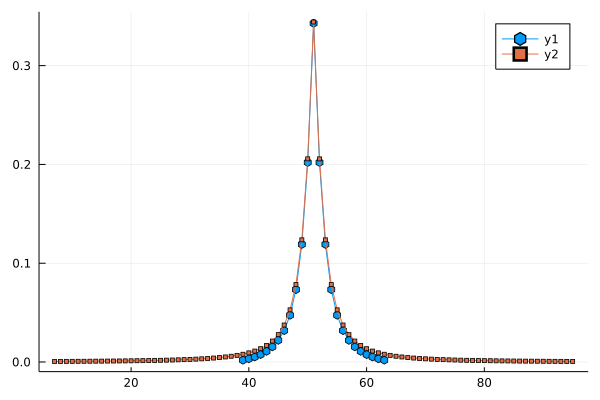

In [13]:

kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = kG
β = mP.β



sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
χsp_ω = kintegrate(kGrid, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
χsp_ω_2 = kintegrate(kGrid, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum_2 = real(sum_freq(χsp_ω_2[nlQ_sp2.usable_ω], [1], sh_2, mP2.β)[1])
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)

plot(nlQ_ch.usable_ω, real(χch_ω[nlQ_ch.usable_ω]),markershape = :hexagon,markersize = 4)
plot!(nlQ_ch2.usable_ω, real(χch_ω_2[nlQ_ch2.usable_ω]),markershape = :square,markersize = 2)

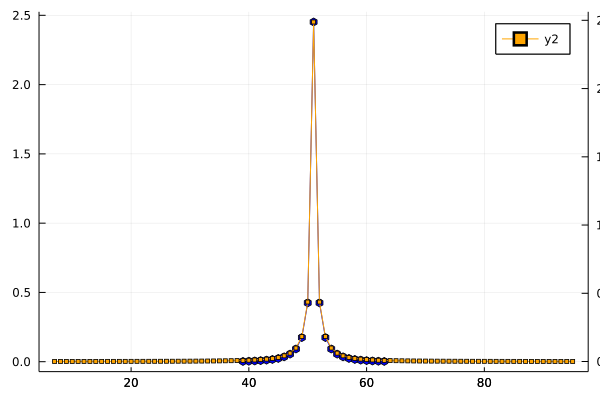

In [14]:
plot(nlQ_sp.usable_ω, real(χsp_ω[nlQ_sp.usable_ω]),markershape = :hexagon,markersize = 4,c=:blue)
plot!(twinx(),[i for i in nlQ_sp2.usable_ω if i != 510], real(χsp_ω_2[[i for i in nlQ_sp2.usable_ω if i != 510]]), c=:orange,markershape = :square,markersize = 2)

In [15]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(39:63,39:63) = 39:63 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 39:63, length: 25
│ ch: 39:63, length: 25
│ usable: 39:63, length: 25
└ χch sum = 0.11848492228135699, rhs = 0.32191248528419064
┌ Info: found 
│   χ_min = -0.0737766303685337
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.0737766303685337, 1.475532607370674]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.03983699048687932
┌ Info: Found λsp 
└   λsp_old = 0.039836990478578554


LoadError: MethodError: no method matching extended_λ(::NonLocalQuantities{ComplexF64, ComplexF64}, ::NonLocalQuantities{ComplexF64, ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::SharedArrays.SharedMatrix{ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::Vector{ComplexF64}, ::Matrix{ComplexF64}, ::Dispersions.ReducedKGrid_cP_3D, ::Vector{Float64}, ::Vector{Float64}, ::ModelParameters, ::SimulationParameters; λsp_guess=0.038836990478578554)
[0mClosest candidates are:
[0m  extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::SharedArrays.SharedArray{ComplexF64, 3}, ::AbstractMatrix{ComplexF64}, ::AbstractArray{ComplexF64, 3}, ::AbstractVector{ComplexF64}, [91m::AbstractVector{ComplexF64}[39m, ::Dispersions.ReducedKGrid, ::Any, ::Any, ::ModelParameters, ::SimulationParameters; λsp_guess) at /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:101

In [16]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc2, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, kG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(7:95,7:95) = 7:95 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 7:95, length: 89
│ ch: 7:95, length: 89
│ usable: 7:95, length: 89
└ χch sum = 0.14040639464346363, rhs = 0.35044316236702344
┌ Info: found 
│   χ_min = -0.07285749318400185
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.07285749318400185, 1.457149863680037]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.037154489104844396
┌ Info: Found λsp 
└   λsp_old = 0.03715448910401293


LoadError: MethodError: no method matching extended_λ(::NonLocalQuantities{ComplexF64, ComplexF64}, ::NonLocalQuantities{ComplexF64, ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::SharedArrays.SharedMatrix{ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::Vector{ComplexF64}, ::Matrix{ComplexF64}, ::Dispersions.ReducedKGrid_cP_3D, ::Vector{Float64}, ::Vector{Float64}, ::ModelParameters, ::SimulationParameters; λsp_guess=0.03615448910401293)
[0mClosest candidates are:
[0m  extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::SharedArrays.SharedArray{ComplexF64, 3}, ::AbstractMatrix{ComplexF64}, ::AbstractArray{ComplexF64, 3}, ::AbstractVector{ComplexF64}, [91m::AbstractVector{ComplexF64}[39m, ::Dispersions.ReducedKGrid, ::Any, ::Any, ::ModelParameters, ::SimulationParameters; λsp_guess) at /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:101

In [17]:
λ_sp3, λ_spch3  = λ_correction!(impQ_sp3, impQ_ch3, FUpDo3, Σ_loc3, Σ_ladderLoc3, nlQ_sp3, nlQ_ch3, bubble3, GLoc_fft3, kG, mP3, sP3)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(7:95,7:95) = 7:95 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 7:95, length: 89
│ ch: 7:95, length: 89
│ usable: 7:95, length: 89
└ χch sum = 0.14497432173766608, rhs = 0.3550256782623339
┌ Info: found 
│   χ_min = -0.07285749318400185
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.07285749318400185, 1.457149863680037]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.03712721773228159
┌ Info: Found λsp 
└   λsp_old = 0.03712721773146674


LoadError: MethodError: no method matching extended_λ(::NonLocalQuantities{ComplexF64, ComplexF64}, ::NonLocalQuantities{ComplexF64, ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::SharedArrays.SharedMatrix{ComplexF64}, ::SharedArrays.SharedArray{ComplexF64, 3}, ::Vector{ComplexF64}, ::Matrix{ComplexF64}, ::Dispersions.ReducedKGrid_cP_3D, ::Vector{Float64}, ::Vector{Float64}, ::ModelParameters, ::SimulationParameters; λsp_guess=0.03612721773146674)
[0mClosest candidates are:
[0m  extended_λ(::NonLocalQuantities, ::NonLocalQuantities, ::SharedArrays.SharedArray{ComplexF64, 3}, ::AbstractMatrix{ComplexF64}, ::AbstractArray{ComplexF64, 3}, ::AbstractVector{ComplexF64}, [91m::AbstractVector{ComplexF64}[39m, ::Dispersions.ReducedKGrid, ::Any, ::Any, ::ModelParameters, ::SimulationParameters; λsp_guess) at /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:101

In [18]:
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

In [19]:
Σ_ladder2 = calc_Σ(nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, FUpDo2, kG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

In [20]:
Σ_ladder3 = calc_Σ(nlQ_sp3, nlQ_ch3, bubble3, GLoc_fft3, FUpDo3, kG, sumHelper_f3, mP3, sP3)
Σ_ladder_corrected3 = Σ_ladder3 .- Σ_ladderLoc3 .+ Σ_loc[1:size(Σ_ladder3,1)];

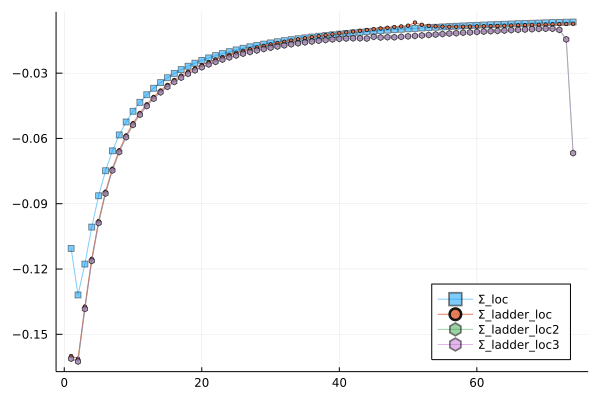

In [21]:
plot(imag(Σ_loc[1:size(Σ_ladder2,1)]), markershape=:square, alpha=0.5, markersize=3, label="Σ_loc", legend=:bottomright)
plot!(imag(Σ_ladderLoc), markershape=:circle, markersize=2, alpha=0.9, label="Σ_ladder_loc")
plot!(imag(Σ_ladderLoc2), markershape=:hexagon, markersize=3, alpha=0.5, label="Σ_ladder_loc2")
plot!(imag(Σ_ladderLoc3), markershape=:hexagon, markersize=3, alpha=0.5, label="Σ_ladder_loc3")

In [22]:
usable_ω = intersect(nlQ_ch.usable_ω, nlQ_sp.usable_ω)
usable_ω2 = intersect(nlQ_ch2.usable_ω, nlQ_sp2.usable_ω)
usable_ω3 = intersect(nlQ_ch3.usable_ω, nlQ_sp3.usable_ω)
usable_ω_common = intersect(usable_ω,usable_ω2,usable_ω3)
println("$(usable_ω) , $(usable_ω2), $(usable_ω_common)")
maximum(abs.(Σ_ladder_ω[usable_ω_common,:,:] .- Σ_ladder_ω2[usable_ω_common,:,:]))

39:63 , 7:95, 39:63


LoadError: UndefVarError: Σ_ladder_ω not defined

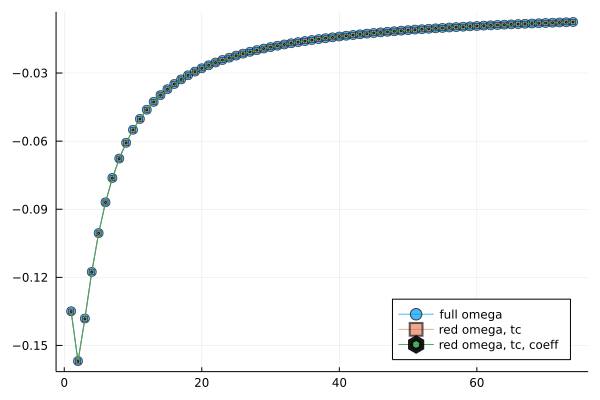

In [23]:
plot(imag(Σ_ladder_corrected[:,1]), markershape=:circle, markersize=5, alpha=0.7, label="full omega", legend=:bottomright)
plot!(imag(Σ_ladder_corrected2[:,1]), markershape=:square, markersize=2.5, alpha=0.6, label="red omega, tc")
plot!(imag(Σ_ladder_corrected3[:,1]), markershape=:hexagon, markersize=1, alpha=0.9, label="red omega, tc, coeff")

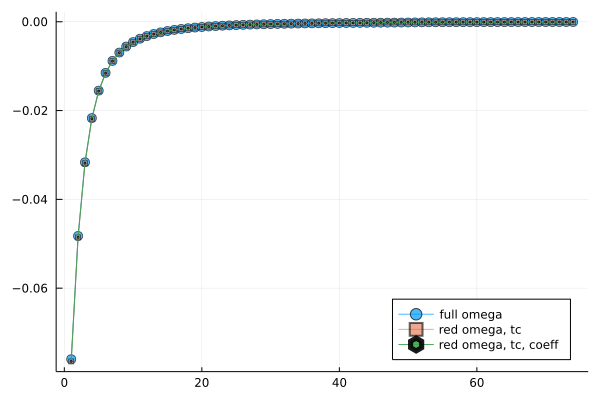

In [24]:
plot(real(Σ_ladder_corrected[:,1]), markershape=:circle, markersize=5, alpha=0.7, label="full omega", legend=:bottomright)
plot!(real(Σ_ladder_corrected2[:,1]), markershape=:square, markersize=2.5, alpha=0.6, label="red omega, tc")
plot!(real(Σ_ladder_corrected3[:,1]), markershape=:hexagon, markersize=1, alpha=0.9, label="red omega, tc, coeff")